LogReg acc: 0.8858695652173914 AUC: 0.9300573888091822
RandomForest acc: 0.9021739130434783 AUC: 0.9331061692969871
LogReg report:
               precision    recall  f1-score   support

           0       0.91      0.83      0.87        82
           1       0.87      0.93      0.90       102

    accuracy                           0.89       184
   macro avg       0.89      0.88      0.88       184
weighted avg       0.89      0.89      0.89       184

RF report:
               precision    recall  f1-score   support

           0       0.91      0.87      0.89        82
           1       0.90      0.93      0.91       102

    accuracy                           0.90       184
   macro avg       0.90      0.90      0.90       184
weighted avg       0.90      0.90      0.90       184



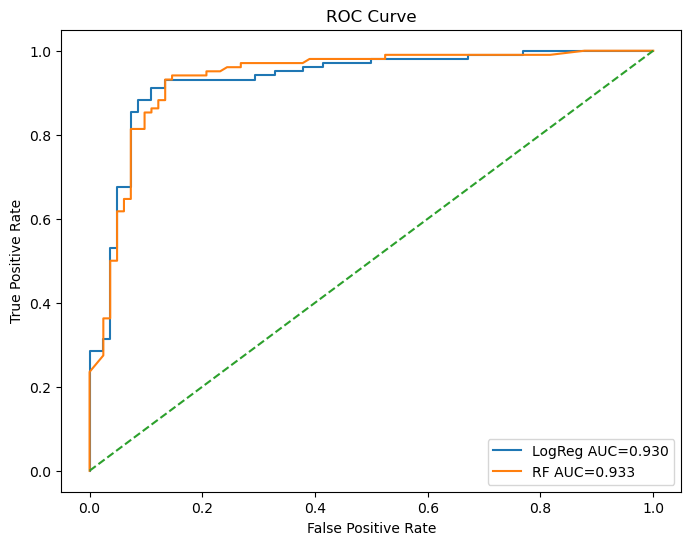

In [8]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, accuracy_score
import matplotlib.pyplot as plt
import pickle

# Load
df = pd.read_csv("heart.csv")

# Assume target
target_col = "HeartDisease"
X = df.drop(columns=[target_col])
y = df[target_col]

# Feature types
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object", "category", "bool"]).columns.tolist()

# Pipeline components
numeric_transformer = Pipeline([("scaler", StandardScaler())])
categorical_transformer = Pipeline([("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocessor = ColumnTransformer([
    ("num", numeric_transformer, numeric_cols),
    ("cat", categorical_transformer, categorical_cols)
])

# Pipelines
logreg_pipe = Pipeline([("preprocessor", preprocessor),
                        ("classifier", LogisticRegression(max_iter=1000, solver="liblinear"))])
rf_pipe = Pipeline([("preprocessor", preprocessor),
                    ("classifier", RandomForestClassifier(n_estimators=200, random_state=42))])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

# Fit
logreg_pipe.fit(X_train, y_train)
rf_pipe.fit(X_train, y_train)

# Predict & probs
y_pred_lr = logreg_pipe.predict(X_test)
y_proba_lr = logreg_pipe.predict_proba(X_test)[:,1]

y_pred_rf = rf_pipe.predict(X_test)
y_proba_rf = rf_pipe.predict_proba(X_test)[:,1]

# Metrics
lr_acc = accuracy_score(y_test, y_pred_lr)
rf_acc = accuracy_score(y_test, y_pred_rf)
lr_auc = roc_auc_score(y_test, y_proba_lr)
rf_auc = roc_auc_score(y_test, y_proba_rf)

print("LogReg acc:", lr_acc, "AUC:", lr_auc)
print("RandomForest acc:", rf_acc, "AUC:", rf_auc)
print("LogReg report:\n", classification_report(y_test, y_pred_lr))
print("RF report:\n", classification_report(y_test, y_pred_rf))

# Save best model
best_model = rf_pipe if rf_acc >= lr_acc else logreg_pipe
pickle.dump(best_model, open("best_model.pkl", "wb"))

# Save test results for inspection
test_results = X_test.copy()
test_results["true"] = y_test.values
test_results["pred_rf"] = y_pred_rf
test_results["pred_lr"] = y_pred_lr
test_results["proba_rf"] = y_proba_rf
test_results["proba_lr"] = y_proba_lr
test_results.to_csv("test_results.csv", index=False)

# Optional: plot ROC
plt.figure(figsize=(8,6))
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_proba_rf)
plt.plot(fpr_lr, tpr_lr, label=f"LogReg AUC={lr_auc:.3f}")
plt.plot(fpr_rf, tpr_rf, label=f"RF AUC={rf_auc:.3f}")
plt.plot([0,1],[0,1],"--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [19]:
import pickle
import pandas as pd

# Load model
model = pickle.load(open("best_model.pkl", "rb"))

# Example new patient (use same column names as training features)
new_patient = {
    "Age": 20,
    "Sex": "F",               # depends on how 'Sex' values are in your CSV (check exact strings)
    "ChestPainType": "ATA",   # use the same categories as present in the dataset
    "RestingBP": 110,
    "Cholesterol": 0,
    "FastingBS": 0,
    "RestingECG": "ST",
    "MaxHR": 98,
    "ExerciseAngina": "N",
    "Oldpeak": 0,
    "ST_Slope": "UP"
}

df_new = pd.DataFrame([new_patient])
pred = model.predict(df_new)            # 0 or 1
proba = model.predict_proba((df_new))[:,1] # probability of class 1 (disease)
result = float(proba[0] * 100)
rounded_result = round(result, 2)

print("Predicted class:", int(pred[0]))
print("Probability of heart disease:")
print(rounded_result) 


Predicted class: 0
Probability of heart disease:
48.5
